In [3]:
from matplotlib import pyplot as plt
import numpy as np
from common_util import NogamiUTSData,NogamiUEData,NogamiConductivityData,setup_axis_default,hdi
from matplotlib import rc
import warnings
import pickle
import copy
from common_util import ParamterizedLinearModel
warnings.filterwarnings("ignore")

#ignore warnings and set preference for matplotlib styles
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])


### Application overview

There is an extraordinary amount of simulatanously ongoing research in the development of fusion nuclear reactors. A major push is the development of advanced tungsten (W) alloys that provide better material properties, that is ultimate tensile stress, uniform elongation, thermal conductivity, and creep stress. Due to the complex physics of alloying, predicting the macroscopic material properties from the constituent metals is presently impossible. 

Another engineering research push is developing cooling strategies for the reactor components exposed to the highest heat fluxes. In typically engineering design, the strategy would be to assess the safety \& performance of a designed component using available material property data, and if safety or perormance design goals are not met for a specific reactor, either redesign the component, or find another alloy. 

Redesign can be a tedious process, especially when it is not certain what the target reactor conditions are. Because the development of advanced tungsten alloys is occuring in parallel to development of cooling strategies, it is useful to know given a particular cooling component and specified reactor conditions how "good" of an alloy is required to meet specified performance and safety critiera. 

The following details an approach for developing _parameteric_ material models that roughly allows the parametric model to interpolate between "better" and "worse" alloys. For ultimate tensile strength, uniform elongation, and thermal conductivity, the procedure is as follows:

1. Generate samples from the predictive distributions for each linear model fit to each alloy, in the respective notebooks.
2. Find the empircal $(1- \alpha) \times 100 \%$ confidence intervals, $\eta_{lb}(T)$, $\eta_{ub}(T)$ respectively, where $\eta$ is a generic material property.
3. Fit the same linear model form as the one chosen for the material property to $T_i,\frac{1}{2} \left(\eta_{ub}(T_i) - \eta_{lb}(T_i)\right)$ and call this model $f_\sigma(T)$
4. Fit a mean model to the predictive distribution data (again using the same linear model form chosen in previous notebooks), call this model call this model $f_\mu(T)$
5. Construct the parametric model:

    $
    f(T,\kappa) = f_\mu(T) + \kappa f_\sigma(T)
    $

The rest of the notebook below demonstrates how we can find $\kappa$ for each material to approximate the temperature dependent property in question. We can then use this $\kappa$ to judge how "good" this material property needs to be for our specific application, with $\kappa = -1,0,1$ roughly meaning bad,average, and great respectively. Obviously $\kappa > 1$ means "material outside the present data set".

### Ultimate Tensile Strength
The plot below demonstrates the best approximate parametric function $f(T,\kappa)$ that can be found to approximate the model fit to the particular tungsten alloy, and the data. The total spread of the parametric model fit to the posterior distributions is shown in the right plot. The parametric model is close enough to the alloy specific models that it's representative power seems reasonable.

fitting material model: K-W3%Re Plate (L)
gamma: -0.009874971584172379 | mean value: 661.2087323191558
----------------------------------------

fitting material model: K-W3%Re Plate (H)
gamma: 0.9330783557604316 | mean value: 763.2544750344182
----------------------------------------

fitting material model: W Plate (H)
gamma: -0.8048543684984278 | mean value: 575.1766237842661
----------------------------------------



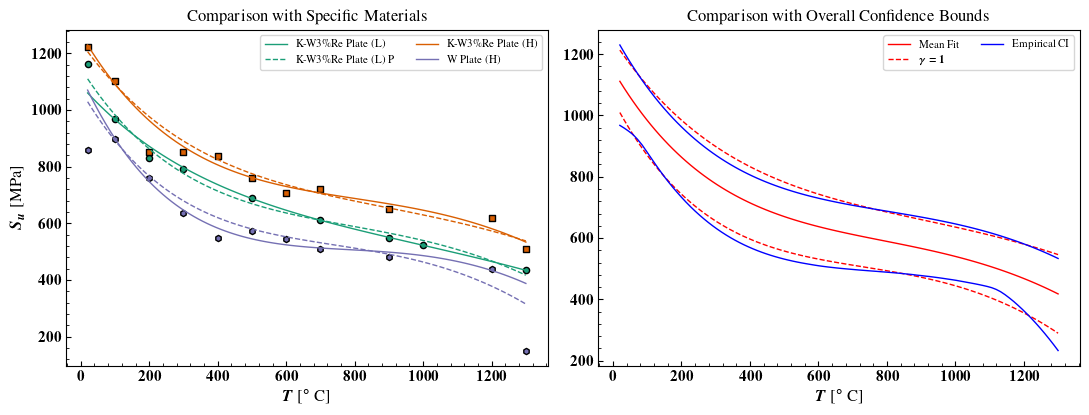

In [7]:
nogami_data = NogamiUTSData()
with open(f'.scratch/uts_posterior_samples.pkl','rb') as f: 
    xs,ys_ =  pickle.load(f)

#some shaping of the samples
with open(f".model/K-W3%Re Plate (H)_uts.pkl","rb") as f:
    model = pickle.load(f)  
    ymax = model.predict(xs)

for i in range(ys_.shape[0]):
    ys_[i,ys_[i] > ymax[i]] = ymax[i]

Xs = np.repeat(xs,ys_.shape[1],axis = 0).flatten()[:,np.newaxis]
ys = ys_.flatten()

pmodel_base = copy.deepcopy(model)  

parametric_model = ParamterizedLinearModel(pmodel_base)
parametric_model.fit_mean(Xs,ys)
parametric_model.fit_spread(xs,ys_)

fig, axes = plt.subplots(ncols = 2,figsize = (11,4.25))
for ax in axes:
    setup_axis_default(ax)

colors = plt.get_cmap('Dark2')(list(range(len(nogami_data.keys()))))

labels = {'K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)',
          'W Plate (H)': 'W Plate (H)'}

markers = ['o','s','h']
i_ = 0
axes[0].set_title('Comparison with Specific Materials')
for col,color,marker in zip(labels,colors,markers):
    print(f'fitting material model: {col}')
    with open(f".model/{col}_uts.pkl","rb") as f:
        model = pickle.load(f)
    
    gamma = parametric_model.find_gamma(model.predict,(xs.min(),xs.max()))
    mv = parametric_model.mean_value((xs.min(),xs.max()),gamma)
    
    print(f'gamma: {gamma} | mean value: {mv}')
    with open('.model/uts_parametric.pkl','wb') as f:
        pickle.dump(parametric_model,f) 

    print('----------------------------------------\n')
    axes[0].plot(xs,model.predict(xs).squeeze(),label = labels[col],color = color,linestyle = '-',lw = 1.0)
    axes[0].plot(xs,parametric_model(xs,gamma).squeeze(),label = f'{labels[col]} P' if i_ == 0 else None,
            color = color,linestyle = '--',lw = 1.0)

    axes[0].scatter(*nogami_data['UTS [MPa] ' + col], s = 20,marker = marker,color = color,edgecolor = 'k')
    i_ +=1

axes[1].set_title('Comparison with Overall Confidence Bounds')


axes[1].plot(xs,parametric_model(xs,0),color = 'red',linestyle = '-',lw = 1.0,label = 'Mean Fit')
axes[1].plot(xs,parametric_model(xs,1),color = 'red',linestyle = '--',lw = 1.0,label = r'$\gamma = 1$')
axes[1].plot(xs,parametric_model(xs,-1),color = 'red',linestyle = '--',lw = 1.0)

confidence_intervals = hdi(ys_,alpha = 0.95).T

for i,ci in enumerate(confidence_intervals):
    model = copy.deepcopy(pmodel_base)

    #plot samples
    axes[1].plot(xs,ci,color = 'blue',linestyle = '-',lw = 1.0,
                 label = 'Empirical CI' if i == 0 else None)

axes[0].set_ylabel(r'$S_{u}$ [MPa]',fontsize = 12)
for ax in axes:
    ax.legend(ncol = 2,fontsize = 8)
    ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = 12)

fig.tight_layout()


### Uniform Elongation

The process is repeated for uniform elongation. The neccessity for temperature dependent spread function is made clear in this case as the $\varepsilon_u$ values converge at high temperatures. The parametric model agree's excellently with the alloy specific models. 

fitting material model: K-W3%Re Plate (L)
gamma: 1.072046393208714 | mean value: 5.134743114091577
----------------------------------------

fitting material model: K-W3%Re Plate (H)
gamma: 0.08932747561952811 | mean value: 2.929142591612544
----------------------------------------

fitting material model: W Plate (H)
gamma: -0.6420413020217818 | mean value: 1.2876687894720371
----------------------------------------



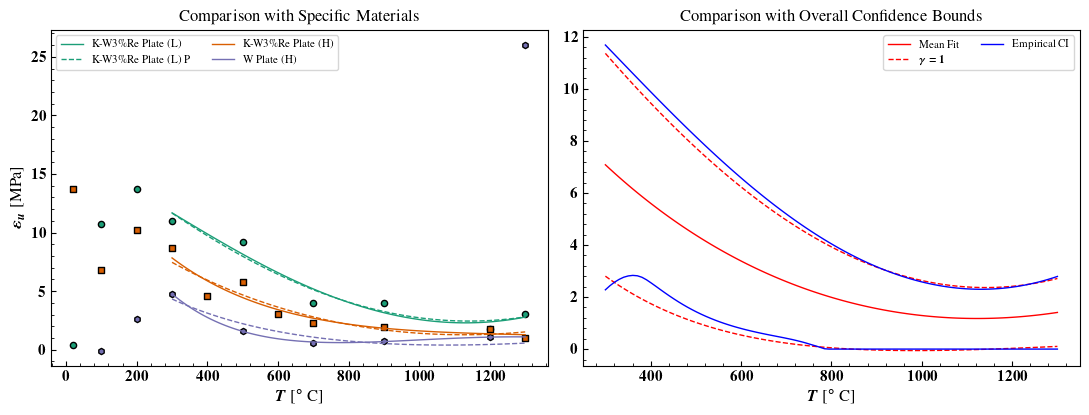

In [ ]:
nogami_data = NogamiUEData()
with open(f'.scratch/ue_posterior_samples.pkl','rb') as f: 
    xs,ys_ =  pickle.load(f)

#some shaping of the samples
with open(f".model/K-W3%Re Plate (L)_ue.pkl","rb") as f:
    model = pickle.load(f)  
    ymax = model.predict(xs)

for i in range(ys_.shape[0]):
    ys_[i,ys_[i] > ymax[i]] = ymax[i]

ys_[ys_ < 0] = 0

Xs = np.repeat(xs,ys_.shape[1],axis = 0).flatten()[:,np.newaxis]
ys = ys_.flatten()

pmodel_base = copy.deepcopy(model)  

parametric_model = ParamterizedLinearModel(pmodel_base)
parametric_model.fit_mean(Xs,ys)
parametric_model.fit_spread(xs,ys_)

fig, axes = plt.subplots(ncols = 2,figsize = (11,4.25))
for ax in axes:
    setup_axis_default(ax)

colors = plt.get_cmap('Dark2')(list(range(len(nogami_data.keys()))))

labels = {'K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)',
          'W Plate (H)': 'W Plate (H)'}

markers = ['o','s','h']
i_ = 0
axes[0].set_title('Comparison with Specific Materials')
for col,color,marker in zip(labels,colors,markers):
    print(f'fitting material model: {col}')
    with open(f".model/{col}_ue.pkl","rb") as f:
        model = pickle.load(f)
    
    gamma = parametric_model.find_gamma(model.predict,(xs.min(),xs.max()))
    mv = parametric_model.mean_value((xs.min(),xs.max()),gamma)

    with open('.model/ue_parametric.pkl','wb') as f:
        pickle.dump(parametric_model,f) 

    print(f'gamma: {gamma} | mean value: {mv}')   

    print('----------------------------------------\n')
    axes[0].plot(xs,model.predict(xs).squeeze(),label = labels[col],color = color,linestyle = '-',lw = 1.0)
    axes[0].plot(xs,parametric_model(xs,gamma).squeeze(),label = f'{labels[col]} P' if i_ == 0 else None,
            color = color,linestyle = '--',lw = 1.0)

    axes[0].scatter(*nogami_data['UE [%] ' + col], s = 20,marker = marker,color = color,edgecolor = 'k')
    i_ +=1

axes[1].set_title('Comparison with Overall Confidence Bounds')

axes[1].plot(xs,parametric_model(xs,0.),color = 'red',linestyle = '-',lw = 1.0,label = 'Mean Fit')
axes[1].plot(xs,parametric_model(xs,1.),color = 'red',linestyle = '--',lw = 1.0,label = r'$\gamma = 1$')
axes[1].plot(xs,parametric_model(xs,-1.),color = 'red',linestyle = '--',lw = 1.0)

confidence_intervals = hdi(ys_,alpha = 0.95).T

for i,ci in enumerate(confidence_intervals):
    model = copy.deepcopy(pmodel_base)

    #plot samples
    axes[1].plot(xs,ci,color = 'blue',linestyle = '-',lw = 1.0,
                 label = 'Empirical CI' if i == 0 else None)

axes[0].set_ylabel(r'$\varepsilon_{u}$ [MPa]',fontsize = 12)
for ax in axes:
    ax.legend(ncol = 2,fontsize = 8)
    ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = 12)

fig.tight_layout()


### Conductivity

Finally, for the conductivity model. This is a bit strange because of the "splined" data at high temperatures, but the agreement between the parametric model and alloy specific models is excellent in the data range, and there is some variablity in the "splined" section before convergence to the high temperature model.

['Pure W (H) Plate', 'K-doped W (H) Plate', 'W-1%Re (H) Plate', 'K-doped W-3%Re (H) Plate', 'W-3%Re (H) Plate']
fitting material model: K-W3%Re Plate (L)
gamma: -0.6818435189752465 | mean value: 111.68850948092319
----------------------------------------

fitting material model: K-W3%Re Plate (H)
gamma: -0.6818435189752465 | mean value: 111.68850948092319
----------------------------------------

fitting material model: W Plate (H)
gamma: 1.0315628874809315 | mean value: 140.24075079832195
----------------------------------------



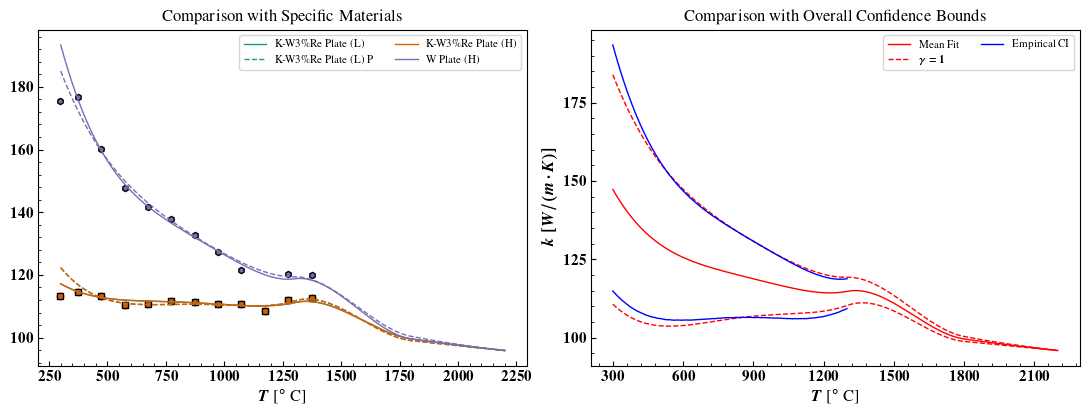

In [15]:
from common_util import StichPolynomialSplineModel

nogami_data = NogamiConductivityData()

with open(f'.scratch/conductivity_posterior_samples.pkl','rb') as f: 
    xs,ys_ =  pickle.load(f)

with open(f'.scratch/conductivity_total_samples.pkl','rb') as f: 
    xt,yt_ =  pickle.load(f)

#some shaping of the samples
with open(f".model/W Plate (H)_k.pkl","rb") as f:
    model = pickle.load(f)  
    ymax = model.predict(xs)

for i in range(ys_.shape[0]):
    ys_[i,ys_[i] > ymax[i]] = ymax[i]
    yt_[i,yt_[i] > ymax[i]] = ymax[i]



Xs = np.repeat(xs,ys_.shape[1],axis = 0).flatten()[:,np.newaxis]
Xt = np.repeat(xt,yt_.shape[1],axis = 0).flatten()[:,np.newaxis]
ys = ys_.flatten()
yt = yt_.flatten()
pmodel_base = copy.deepcopy(model)  

T_eval = np.array([1300.,1800.])[:,np.newaxis]   
parametric_model = ParamterizedLinearModel(pmodel_base,model_spread= pmodel_base.model)
parametric_model.fit_mean(Xs,ys,T_eval)
parametric_model.fit_spread(xt,yt_)

fig, axes = plt.subplots(ncols = 2,figsize = (11,4.25))
for ax in axes:
    setup_axis_default(ax)

colors = plt.get_cmap('Dark2')(list(range(len(nogami_data.keys()))))


labels = {'K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)',
          'W Plate (H)': 'W Plate (H)'}

translation = {'K-W3%Re Plate (L)':'K-doped W-3%Re (H) Plate',
                'K-W3%Re Plate (H)': 'K-doped W-3%Re (H) Plate',
                'W Plate (H)': 'Pure W (H) Plate'}

print(nogami_data.keys())

markers = ['o','s','h']
i_ = 0
axes[0].set_title('Comparison with Specific Materials')
xplot = np.linspace(xs.min(),2200,1000)[:,np.newaxis]
for col,color,marker in zip(labels,colors,markers):
    print(f'fitting material model: {col}')
    with open(f".model/{col}_k.pkl","rb") as f:
        model = pickle.load(f)
    
    gamma = parametric_model.find_gamma(model.predict,(xs.min(),xs.max()))
    mv = parametric_model.mean_value((xs.min(),xs.max()),gamma)

    with open('.model/k_parametric.pkl','wb') as f:
        pickle.dump(parametric_model,f) 

    print(f'gamma: {gamma} | mean value: {mv}')   

    print('----------------------------------------\n')
    axes[0].plot(xplot,model.predict(xplot).squeeze(),label = labels[col],color = color,linestyle = '-',lw = 1.0)
    axes[0].plot(xplot,parametric_model(xplot,gamma).squeeze(),label = rf'{labels[col]} P' if i_ == 0 else None,
            color = color,linestyle = '--',lw = 1.0)

    axes[0].scatter(*nogami_data[translation[col]], s = 20,marker = marker,color = color,edgecolor = 'k')
    i_ +=1

axes[1].set_title('Comparison with Overall Confidence Bounds')

axes[1].plot(xplot,parametric_model(xplot,0.),color = 'red',linestyle = '-',lw = 1.0,label = 'Mean Fit')
axes[1].plot(xplot,parametric_model(xplot,1.),color = 'red',linestyle = '--',lw = 1.0,label = r'$\gamma = 1$')
axes[1].plot(xplot,parametric_model(xplot,-1.),color = 'red',linestyle = '--',lw = 1.0)

confidence_intervals = hdi(ys_,alpha = 0.95).T

for i,ci in enumerate(confidence_intervals):
    model = copy.deepcopy(pmodel_base)

    #plot samples
    axes[1].plot(xs,ci,color = 'blue',linestyle = '-',lw = 1.0,
                 label = 'Empirical CI' if i == 0 else None)

ax.set_xlabel(r'Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,2300,300))
ax.set_yticks(np.arange(100,200,25))
ax.set_ylabel(r'$k \ [W/(m \cdot K)]$',fontsize = 12)

for ax in axes:
    ax.legend(ncol = 2,fontsize = 8)
    ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = 12)

fig.tight_layout()


### Creep

The approach for parametrically varying creep is different, and admittadely arbitary because of the lack of available data for tungsten. An _improved by_ $\kappa$ model has 

$
C \gets C (1 + \kappa) \\ 
\beta_0 \gets \beta_0 ( 1 + \kappa)
$

Meaning that the material rate constant $C$ and intercept $\beta_0$ for the creep rupture stress $S_t$ increase by $\kappa$. This is visually demonstrated below for $\kappa = \{-0.05,0.05\}$ with the fitted creep model developed in the notebook [creep_modeling.ipynb](creep_modeling.ipynb) for two temperatres, $T = 1000,1200 \  ^\circ C$. Varying $\kappa$ can still give us useful information for a specific cooling component and reactor operating conditions what the required creep ruture behavior needs to be in relation to available experimental results.

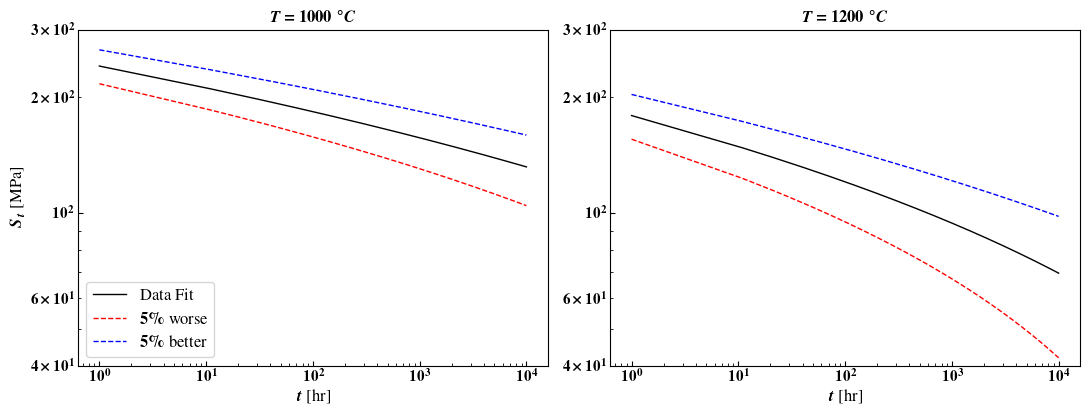

In [16]:
from common_util import LarsonMiller

with open('.model/creep_larson_miller_rx_w.pkl','rb') as f:
    model = pickle.load(f)

fig, axes = plt.subplots(ncols = 2,figsize = (11,4.25))
temps = [1000,1200]
times = np.linspace(1,1e4,1000)
improve = [-0.05,0.05]
for ax,T in zip(axes,temps):
    setup_axis_default(ax)
    ax.set_title(rf'$T = {T}$ $^\circ C$',fontsize = 12)
    ax.plot(times,model.predict(times*3600,T*np.ones_like(times) + 273.15),color = 'k',linestyle = '-',lw = 1.0,label = 'Data Fit')
    for imp,color,label in zip(improve,['red','blue'],[r'$5 \%$ worse',r'$5 \%$ better']):
        improved_model = model.make_improved_model(imp)
        ax.plot(times,improved_model.predict(times*3600,T*np.ones_like(times) + 273.15),
                color = color,ls = '--',lw = 1.0,label = label)
        
    ax.set_xlabel('$t$ [hr]',fontsize =12)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([40,300])

axes[0].set_ylabel('$S_t$ [MPa]',fontsize = 12)
axes[0].legend(fontsize = 12)
fig.tight_layout()


### Summary Graphics

The question then becomes: How do we _present_ this information? That is, once we find the parametric material representation $\{\kappa_{UTS}, \kappa_{UE}, \kappa_{k},\kappa_{C}\}$ how do we quickly judge what this means? 

I'm partial to _radar plots_ for this purpose. We can quickly visually demonstrate how good a material _required_ for specific fusion reactor operating conditions and cooling component is compared with known alloys. 

As an example below, suppose we found from our analysis that a $W$ alloy requires a reasonable ultimate tensile strength ($\kappa = 0.6$) a as of yet unobtained uniform elongation $\kappa = 2$, a decent thermal conductivity $\kappa = 0.5$ and a $25\%$ higher creep stress. This fictitous alloy is summarized in the below plot. The properties are compared as functions of temperature with _existing_ alloys (and the available data for creep rupture stress $S_t$ assuming a time of 1 year).

The relative properties of the alloys are summarized in the radar plot, where the color schemes clearly demonstrate that this new alloy will be greatly superior to the existing alloys.

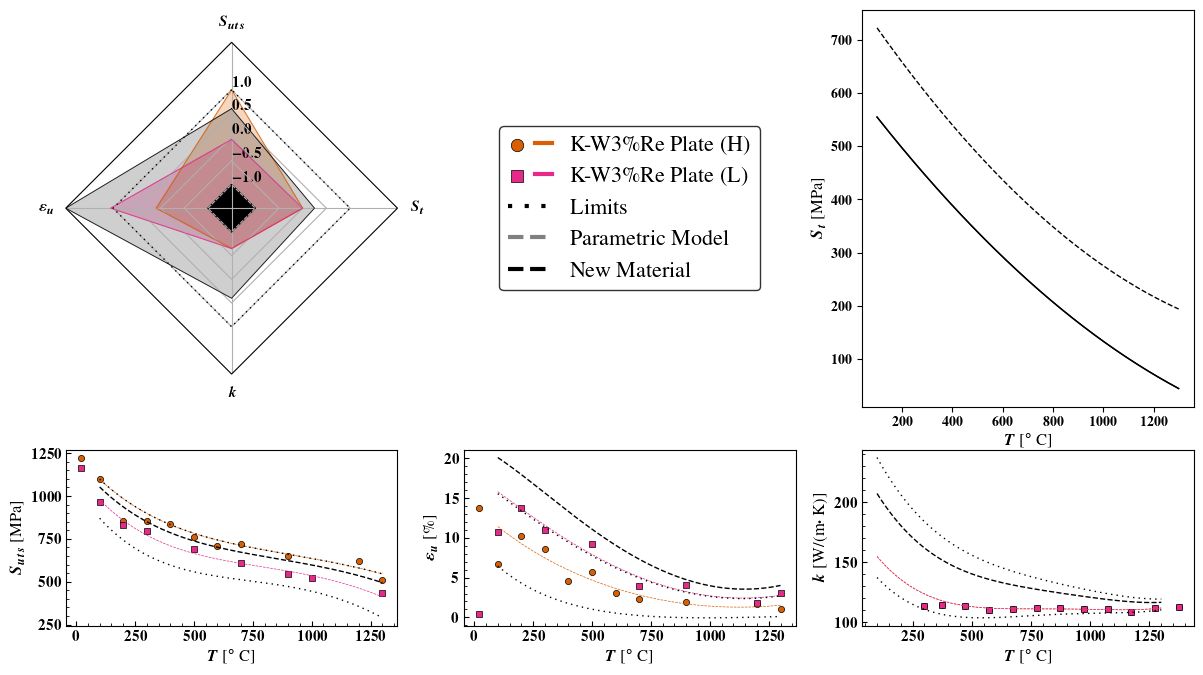

In [44]:
from matplotlib import pyplot as plt    
from common_util import make_radar_plot, ParamterizedLinearModel, NogamiDataCollection,setup_axis_default
import pickle
from typing import Tuple, List, Iterable
import numpy as np  
import warnings
from matplotlib import rc
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from functools import cache

warnings.filterwarnings("ignore")
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

@cache
def get_opt_parameter(material_name: str, 
                      material_property: str,
                      xlim: Tuple = (500,1300)):

    """
    given a material, find the parameter "gamma" which optmially 
    represents the material property in the given temperature range
    in an L2 sense.
    """
    try:
        with open(f'.model/{material_name}_{material_property}.pkl','rb') as f:
            material_model = pickle.load(f)  
        
        with open(f'.model/{material_property}_parametric.pkl','rb') as f:
            parametric_model = pickle.load(f)
    except FileNotFoundError as fnfe:
        raise FileNotFoundError(f"Model for {material_name} not found: {str(fnfe)}")

    gamma = parametric_model.find_gamma(material_model.predict,xlim)
    return gamma

@cache
def get_parameter_representation(material_name: str,
                                 xlim: Tuple = (500,1300)):

    """
    get the optimal parametric representation of the material
    from model files
    """
    params = []
    param_names = ['uts','ue','k']
    for param_name in param_names:
        params.append(get_opt_parameter(material_name,param_name,xlim = xlim))
    
    #for creep
    params.append(0)

    return params

class ParametricMaterialPlot:

    """
    A parametric material property plot. This plot consists of 
    temperature dependent material properties, showing the parametric variation
    as well as a summary plot showing the parametric representation of each material,
    which is a "radar" or "spider" plot.

    This will have to be extended in the future to include more material properties
    which will have to be approached on a case by case basis as the complexity of the
    figure is somewhat difficult to generalize.
    """

    labels = [r'$S_{uts}$',r'$\varepsilon_u$',r'$k$',r'$S_t$']
    ax_labels = [r'$S_{uts}$ [MPa]',r'$\varepsilon_u$ [\%]',r'$k$ [W/(m$\cdot$ K)]','$S_t$ [MPa]']
    param_names = ['uts','ue','k']

    def __init__(self,figsize = (6,6),
                 fontsize = 12,
                 labelsize = 11):
        
        self.fontsize = fontsize    
        make_radar_plot(4,frame = 'polygon')
        self.fig = plt.figure(figsize = figsize) 
        self.axes = self.fig.subplot_mosaic(
            """
            AEF
            BCD
            """,
            per_subplot_kw= {'A': dict(projection = 'radar')},
            height_ratios= [2.25,1]
        )

        self.fig.subplots_adjust(hspace = 0.15,top = 0.98,right = 0.99,left = 0.05,bottom = 0.1)
        self.data = NogamiDataCollection()
        self.axes = [ax for ax in self.axes.values()]
        self.setup_property_plots(fontsize = fontsize,labelsize = labelsize)
        self.setup_radar_plot(fontsize = fontsize,labelsize = labelsize)
        self.setup_legend_axis()
        self._legend_items = {}

    def setup_property_plots(self,fontsize = 12,labelsize = 11):
        """ 
        setup the property plots for the material properties
        """
        for ax,label in zip(self.axes[3:],self.ax_labels):
            setup_axis_default(ax,labelsize = labelsize)
            ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = fontsize)
            ax.set_ylabel(label,fontsize = fontsize)

    def setup_radar_plot(self,fontsize = 12,labelsize = 11):
        """ 
        setup the radar plots for the parametric material property summary
        """
        self.theta = make_radar_plot(4,frame = 'polygon')
        self.axes[0].set_varlabels(self.labels,fontsize = fontsize)
        self.axes[0].tick_params('both',labelsize = labelsize)

    def setup_legend_axis(self):
        self.axes[1].axis('off')

    def legend(self,patches : List = [],names : List = [],fontsize = 12):
        """
        add the legend to the empty axis
        """
        parametric_patch = Line2D([],[],color = 'grey',lw = 3,ls = '--',label = 'Parametric Model')

        legend  = self.axes[1].legend(list(self._legend_items.values()) + [parametric_patch] + patches,
                            list(self._legend_items.keys()) + ['Parametric Model'] + names,
                            handler_map = {tuple: HandlerTuple(ndivide=None)},
                            fontsize =fontsize,
                            loc = 'center',
                            markerscale = 2.)
        
        legend.get_frame().set_edgecolor('k')


    def plot_lims(self,*args,
                  xlim: Tuple = (100,1300),
                  label_lw = 3, 
                  **kwargs):
        """ 
        plot the "limits" i.e. the minimum and maximum values of the parametric representation
        both on the material property plots and the summary plot
        """
        xplot = np.linspace(xlim[0],xlim[1],1000)[:,np.newaxis]
        for ax,pname in zip(self.axes[3:],self.param_names):
            with open(f'.model/{pname}_parametric.pkl','rb') as f:
                model = pickle.load(f)
            for p_rep in [-1,1]:
                ax.plot(xplot,model(xplot,p_rep),**kwargs)

        for bound in [[-1,-1,-1,-1],[1,1,1,1]]:
            self.axes[0].plot(self.theta,bound,**kwargs)
        
        self.axes[0].fill(self.theta,[-1,-1,-1,-1],color = 'k',alpha = 1.)

        if 'lw' in kwargs:
            kwargs.pop('lw')
        if 'linewidth'  in kwargs:
            kwargs.pop('linewidth')
        
        kwargs['lw'] = label_lw

        self._legend_items['Limits'] = Line2D([],[],**kwargs,label = 'Limits')


    def plot_creep(self,ax: plt.Axes,
                        creep_time: float,
                        xplot: np.ndarray):

        with open('.model/creep_larson_miller_rx_w.pkl','rb') as f:
            model = pickle.load(f)

        ax.plot(xplot.squeeze(),model.predict(creep_time*np.ones_like(xplot.squeeze()),xplot.squeeze() + 273.15),
                color = 'k',linestyle = '-',lw = 1.0,label = 'Data Fit')
        
        ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = self.fontsize)
        ax.set_ylabel('$S_t$ [MPa]',fontsize = self.fontsize)
    
    def plot_to_radar(self,params: Iterable,
                            color = 'k',
                            alpha = 0.1875,
                            lw = 0.5):
        
        self.axes[0].plot(self.theta,params,
                            lw = lw,color = color)
        self.axes[0].fill(self.theta,params,
                          alpha = alpha,color = color)

    def plot_material(self,material_name: str,
                            xlim: Tuple = (100,1300),
                            marker = None,
                            s = 20,
                            color = None,
                            alpha = 0.1875,
                            label_lw = 3,
                            creep_time = 3600*8760):
        """ 
        plot the temperature dependent 
        material properties and the parametric representation of the material
        on the radar plot
        """
        
        xplot = np.linspace(xlim[0],xlim[1],1000)[:,np.newaxis]
        p_rep = get_parameter_representation(material_name) 
        for ax,dat,gamma,i in zip(self.axes[3:],self.data[material_name],p_rep, range(len(p_rep))):
            sp = ax.scatter(dat[0],dat[1],color = color,s = s,marker = marker,edgecolor = 'k',lw = 0.5)
            
            with open(f'.model/{material_name}_{self.param_names[i]}.pkl','rb') as f:
                model = pickle.load(f)
            
            label = r'' + material_name.replace('%','\%')
            mlp = Line2D([],[],color = color,lw = label_lw,label = label)

            with open(f'.model/{self.param_names[i]}_parametric.pkl','rb') as f:
                model = pickle.load(f)
            
            ax.plot(xplot,model(xplot,gamma),color = color,ls = '--',lw = 0.5)

            self._legend_items[label] = (sp,mlp)
        

        self.plot_to_radar(p_rep,color = color,alpha = alpha)
        
        #plot creep data
        if creep_time is not None:
            self.plot_creep(self.axes[2],creep_time,xplot)
        else:
            self.axes[2].axis('off')
        
        

alloy_names = ['K-W3%Re Plate (H)','K-W3%Re Plate (L)']
markers = ['o','s','h']
colors = plt.get_cmap('Dark2')(np.arange(0.2,0.8,0.2))
property_plot = ParametricMaterialPlot(figsize = (12,7))
for alloy,color,marker in zip(alloy_names,colors,markers):
    property_plot.plot_material(alloy,marker = marker,color = color,s = 20,alpha = 0.25)

property_plot.plot_lims(color = 'k',lw = 1.,ls = (0,(1,3)))
property_plot.axes[0].set_rgrids([-1,-0.5,0.,0.5,1.],angle = 0)

property_plot.axes[0].set_ylim([-1.5,2.])


params = [0.6,2.,0.4,0.25]
param_names = ['uts','ue','k']
T_plot = np.linspace(100,1300,1000)

for param,param_name,ax in zip(params,param_names,property_plot.axes[3:]):
    with open(f'.model/{param_name}_parametric.pkl','rb') as f:
        model = pickle.load(f)  
    
    ax.plot(T_plot,model(T_plot[:,np.newaxis],param),color = 'k',lw = 1.0,ls = '--')

patch = Line2D([],[],color = 'k',lw = 3,ls = '--',label = 'New Material')

with open(f'.model/creep_larson_miller_rx_w.pkl','rb') as f:
    model = pickle.load(f)

ONE_YEAR= 8760*3600

new_model = model.make_improved_model(params[-1])
property_plot.axes[2].plot(T_plot,
                           new_model.predict(ONE_YEAR*np.ones_like(T_plot),T_plot + 273.15),
                           color = 'k',linestyle = '--',lw = 1.0)

property_plot.plot_to_radar(params,color = 'k',lw = 0.5)

property_plot.legend([patch],['New Material'],fontsize = 16)
property_plot.fig.savefig('images/parametric_material_plot.svg')
